# DLLP 1 - Basics of pytorch

In this notebook, we are going to build a first deep(-ish) neural network, train it and test it on a simple problem. Let's start by importing the libraries that we will need and check that everything works.

In [1]:
import torch
print("pytorch version:",torch.__version__)
print("Is GPU computation available?", torch.cuda.is_available())

# this is only relevant for people with a MacBook M1 and pytorch >= 2.0
print("(Mac M1 only) Is GPU computation available?", torch.backends.mps.is_available())

import matplotlib.pyplot as plt
import numpy as np
import sklearn

pytorch version: 2.2.2
Is GPU computation available? True
(Mac M1 only) Is GPU computation available? False


## Tensors

Before starting with the neural network proper, let's go over the properties of the tensor data structure, as we will have to manipulate tensors and go back and forth between tensor representations and other types (numpy arrays, lists, ...).

Let's start by creating a tensor where all the cells are filled with values. As in numpy, we have pre-trained functions for zeros and ones.

In [2]:
# tensor representing a matrix 3x4, filled with zeros
t_0 = torch.zeros(3, 4)
print("Type of the tensor variable t_0:", type(t_0))
print("Shape of the tensor:", t_0.shape)
print(t_0)

# tensor of the same size, filled with ones
t_1 = torch.ones(3, 4)
print(t_1)

# we can multiply everything by a single value
t_3 = t_1 * 3.3
print(t_3)

Type of the tensor variable t_0: <class 'torch.Tensor'>
Shape of the tensor: torch.Size([3, 4])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[3.3000, 3.3000, 3.3000, 3.3000],
        [3.3000, 3.3000, 3.3000, 3.3000],
        [3.3000, 3.3000, 3.3000, 3.3000]])


And of course, we can create tensors filled with (pseudo-)random numbers. In that case, we always want to seed the (pseudo-)random number generator of pytorch.

You will notice that when you re-run the cell below multiple times, you will get different results. Fix the random seed so that you always get the same result. Documentation: https://pytorch.org/docs/stable/generated/torch.manual_seed.html

In [3]:
# a 3x4 tensor filled with random values; if not specified, they are within [0,1]
t_random = torch.rand(3, 4)
print(t_random)

tensor([[0.2858, 0.6293, 0.2992, 0.5637],
        [0.8682, 0.0132, 0.6417, 0.1361],
        [0.6964, 0.0690, 0.3627, 0.1831]])


Again, running the previous cell multiple times will generate a tensor filled with different values. This is due to the (pseudo-)random number generation. In pytorch, [ensuring reproducibility is not always straightforward](https://pytorch.org/docs/stable/notes/randomness.html), but in this case, we can just set the random seed before calling torch.rand:

```
torch.manual_seed(42)
```
Try to add the line before the call to torch.rand, and see what happens.

A last, but useful way to initialize tensors is by passing them lists or other types of common python data structures. This is pretty easy, just pass the list as an argument and the builder function of the tensor class will take care of everything else. Of course, tensors also have functions to be converted to other data structures, for easier manipulations.

In [4]:
# tensor from a list
a_list = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
t_from_list = torch.tensor(a_list)
print(t_from_list)

# tensor to list
print("Tensor coverted to list:", t_from_list.tolist())

# tensor to numpy array
print("Tensor converted to numpy array:", t_from_list.numpy())

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])
Tensor coverted to list: [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
Tensor converted to numpy array: [[0 1 2]
 [3 4 5]
 [6 7 8]]


Manipulating the shape of the tensors will be fundamental in the following. Here below are a few utility functions that might come in handy, starting from the "*_like()" family.

In [5]:
# the *_like() functions can create new tensors by automatically copying the shape of a target tensor
t_zeros = torch.zeros_like(t_random)
print(t_zeros, t_zeros.shape)

# there are several functions of this type: zeros_like(), ones_like(), rand_like()
# write the code to generate a tensor filled with ones, with the same shape as t_random

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) torch.Size([3, 4])


Other utility functions can directly change the shape of a tensor, without altering the data contained in it. This will be particularly useful when will have the size of a sample in our problem (for example, a vector of features) and we will have to add an extra dimension to the tensor to pass a single sample to the neural network, which would be expecting a tensor of size (n_samples, n_features).

In [8]:
# let's say that we have a tensor with a single dimension, representing a sample in our problem
# each sample in our problem will have n_features
n_features = 10
one_sample = torch.rand(n_features)
print("One sample in our problem:", one_sample)
print("Shape:", one_sample.shape)

# however, as we will see, neural networks in pytorch expect in input BATCHES OF SAMPLES,
# or in other words, several samples at the same time; or in other words again,
# a tensor of size (n_samples, n_features). This can be annoying once the network is
# trained, and we just want to pass ONE sample to obtain a prediction; luckily, we can
# use the 'unsqueeze()' to create a new tensor with one extra dimensions (of size 1),
# perfectly compatible with the input required by our neural network
one_sample_reshaped = one_sample.unsqueeze(dim=0)
print("New shape of the sample:", one_sample_reshaped.shape)

# if, on the other hand, we have the OUTPUT of a neural network that will again
# be a tensor (n_samples, n_outputs) but we passed one single sample and we would
# like to manipulate it later as a simple (n_outputs,) vector, we can use 'squeeze()'
# to remove a dimension with a size of 1 and obtain our (n_outputs,) vector
n_outputs = 3
network_output = torch.rand(1, n_outputs)
print("Network output of shape:", network_output.shape)

network_output_reshaped = network_output.squeeze()
print("Network output, new shape:", network_output_reshaped.shape)

# imagine now that your sample is an image, a matrix of size (height, width)
height = 800
width = 600
sample_image = torch.rand(width, height)
print("Shape of the sample image:", sample_image.shape)

# try to transform it with unsqueeze() and check its new shape
print("New shape, after unsqueeze(dim=0):", sample_image.unsqueeze(dim=0).shape)

One sample in our problem: tensor([0.4562, 0.4077, 0.9175, 0.3011, 0.0191, 0.4687, 0.7039, 0.1397, 0.0601,
        0.0255])
Shape: torch.Size([10])
New shape of the sample: torch.Size([1, 10])
Network output of shape: torch.Size([1, 3])
Network output, new shape: torch.Size([3])
Shape of the sample image: torch.Size([600, 800])
New shape, after unsqueeze(dim=0): torch.Size([1, 600, 800])


There are other ways to modify the shape of a tensor. For example '.view()' can transform it without changing the elements inside. However, the total number of elements in the tensor has to stay the same. Interestingly, '.view()' does not copy the original tensor; it just present the same data in another shape, using the same original allocated memory, so it's pretty convenient to limit the amount of resources consumed. Still, you have to keep in mind that it's _still the same object_, so modifying the view of a tensor also modifies the original tensor.

In [ ]:
t_random = torch.rand(3, 4)
print("A (3,4) random tensor:\n", t_random)

t_random_another_view = t_random.view(2, 6)
print("Same tensor, seens with a shape (2, 6); total number of elements is still 12:\n", t_random_another_view)

# however, be very very careful; as the memory is shared, a view is just a reference
# to the same tensor, so changing an element in the original tensor changes it in any view
t_random[1,2] = 4.0
print("Original tensor:", t_random)
print("View:", t_random_another_view)

# 'view' can also try to guess the correct shape needed for an operation, calling
# the method with a '-1' argument, '.view(-1)
t_weird = torch.tensor([[1.0], [1.0], [1.0]])
print("Shape of a weird tensor:", t_weird.shape)
t_comparison = torch.tensor([1.0, -1.0 , 2.0], dtype=torch.float)

# this line will give you a very weird result
print("Weird result:", t_weird > t_comparison)
# while this one has the expected behavior, with '.view(-1)' trying to guess the proper shape
print("More expected result:", t_weird.view(-1) > t_comparison)

A (3,4) random tensor:
 tensor([[0.1450, 0.4914, 0.2716, 0.4860],
        [0.9923, 0.5675, 0.4093, 0.4880],
        [0.8382, 0.9840, 0.3668, 0.1878]])
Same tensor, seens with a shape (2, 6); total number of elements is still 12:
 tensor([[0.1450, 0.4914, 0.2716, 0.4860, 0.9923, 0.5675],
        [0.4093, 0.4880, 0.8382, 0.9840, 0.3668, 0.1878]])
Original tensor: tensor([[0.1450, 0.4914, 0.2716, 0.4860],
        [0.9923, 0.5675, 4.0000, 0.4880],
        [0.8382, 0.9840, 0.3668, 0.1878]])
View: tensor([[0.1450, 0.4914, 0.2716, 0.4860, 0.9923, 0.5675],
        [4.0000, 0.4880, 0.8382, 0.9840, 0.3668, 0.1878]])
Shape of a weird tensor: torch.Size([3, 1])
Weird result: tensor([[False,  True, False],
        [False,  True, False],
        [False,  True, False]])
More expected result: tensor([False,  True, False])


The '.reshape()' function is an alternative to '.view()'; it will try to return a reshaped view of the original tensor, if possible; otherwise, it will return a reshaped copy of the original, still preserving the same number of elements and their values.

Of course, it's possible to perform a considerable amount of efficient operations over tensors, for example matrix multiplications.

In [9]:
t_weights = torch.rand(3, 4)
print("Let's pretend that this (3,4) random tensor describes the weights of a neural network module:\n", t_weights)

t_sample = torch.ones(4,1)
print("While this is a sample:", t_sample)
print(t_sample.shape)

t_result = t_weights @ t_sample
print(t_result)

# interestingly, if we initialize a 1-dimensional tensor, the matrix multiplication
# will be treated as a matrix-vector multiplication
t_sample_2 = torch.ones(4)
t_result_2 = t_weights @ t_sample_2
print(t_result_2)

Let's pretend that this (3,4) random tensor describes the weights of a neural network module:
 tensor([[0.5394, 0.6901, 0.3935, 0.7495],
        [0.1159, 0.7446, 0.5905, 0.5302],
        [0.1363, 0.4987, 0.3101, 0.8936]])
While this is a sample: tensor([[1.],
        [1.],
        [1.],
        [1.]])
torch.Size([4, 1])
tensor([[2.3725],
        [1.9813],
        [1.8387]])
tensor([2.3725, 1.9813, 1.8387])


More importantly, tensors can store gradients. The gradients are computed automatically when a `backward()` method is invoked, on the basis of the last call to `forward()` (which is some time an implicit part of the operations performed on the tensor).

Consider the example below: we have two tensors, t_A and t_B. When we compute the sum of squared difference of their arguments, storing it in tensor t_C, `forward()` is called. Calling `backward()` on the resulting tensor t_C will update the gradient information stored in both t_A and t_B.

In [10]:
# tensor initialization; note that we specifiy explicitly requires_grad=True
# to enable the computation of gradients (the default is false)
t_A = torch.tensor([1.,2], requires_grad=True)
t_B = torch.tensor([4.,4], requires_grad=True)

# sum of squared differences between elements of t_A and t_B
t_C = ((t_A - t_B)**2).sum()

But how does t_C 'know' which gradients to update when calling `.backward()`? The gradients are stored in other variables, after all. Well, t_C recorded all interactions with other tensors that resulted in its computation, in an internal attribute of the tensor called **computational graph**. We can even visualize the computational graph of t_C, using the `pytorchviz` library built by [Sergey Zagoruyko](https://github.com/szagoruyko) on top of pytorch. Let's give it a try, even though it might take some time to install.

In [ ]:
!pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master --quiet

  Preparing metadata (setup.py) ... done


In [12]:
from torchviz import make_dot

# before calling the 'make_dot' function, we need to define a dictionary to associate
# names (strings) to the tensors that we declared
params_dict = {"t_A" : t_A, "t_B" : t_B, "t_C" : t_C}
make_dot(t_C, params=params_dict)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

The blue nodes in the graph represent tensors that require gradients; green nodes are tensors passed in as outputs; grey nodes are functions that have been applied to the tensors.

Now, calling backward() on t_C will compute $\frac{\partial \texttt{t_C}}{\partial \texttt{t_A}_i}$ and $\frac{\partial \texttt{t_C}}{\partial \texttt{t_B}_i}$ for each element $i$ in tensors t_A and t_B. Since the tensors contain 2 elements, if we visualize them as points on a 2-dimensional plane, the direction opposite to the gradient from each point represented by t_A and t_B goes towards each other (reducing the sum of squared differences).

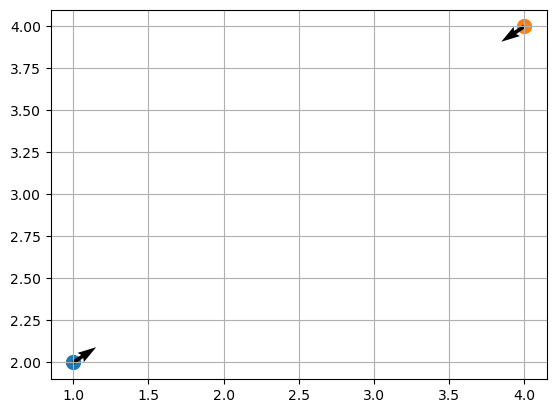

In [13]:
# updating gradients in t_A and t_B, computing the partial derivatives with respect to
# each element of t_A and t_B using the information from t_C
t_C.backward()

# we use the context no_grad() to avoid having to '.detach()' each tensor before using it
with torch.no_grad() :

    # create a figure using matplotlib; returns a reference to a figure
    # and to the subplots of the figure (our figure only has one sublot)
    fig, ax = plt.subplots()
    ax.grid()

    # first, plot the points corresponding to t_A and t_B (both tensors are 2D)
    ax.scatter(t_A[0], t_A[1], s=100)
    ax.scatter(t_B[0], t_B[1], s=100)

    # then, plot an arrow that starts from the point and goes in the direction
    # *opposite* to the gradient
    ax.quiver(t_A[0], t_A[1], -t_A.grad[0], -t_A.grad[1])
    ax.quiver(t_B[0], t_B[1], -t_B.grad[0], -t_B.grad[1])

Now, what happens if we try to update the values inside t_A and t_B following the information we just got from the gradients, so going in the "opposite direction" to the gradient? What if we do that in a loop? Try to predict what is going to happen, then run the code below to produce an animation.

In [14]:
# re-initialize the tensors here
t_A = torch.tensor([1.,2], requires_grad=True)
t_B = torch.tensor([4.,4], requires_grad=True)

# data structures to keep track of the evolution of the values
points = {"t_A" : [], "t_B" : []}
gradients = {"t_A" : [], "t_B" : []}
# this weird chain of t_A.detach().clone().numpy() below is necessary to avoid issues:
# - .detach() is used to access values of tensors that require gradients
# - .numpy() just gives us a numpy view of the tensor, BUT IT IS STILL A REFERENCE
# TO THE VARIABLE! So, if the values are modified in the original tensor variable,
# they are also modified in all numpy views of that variable
# - .clone() is to avoid that problem, it copies the tensor before obtaining the numpy values
points["t_A"].append(t_A.detach().clone().numpy())
points["t_B"].append(t_B.detach().clone().numpy()) # just calling .numpy() would pass values by reference,

# run for a certain number of iterations
max_iterations = 10
# step performed when adjusting tensor's element values
step = 1e-2
print("Running iterations...")
for iteration in range(0, max_iterations) :

  with torch.enable_grad() :
    # compute function
    t_C = ((t_A - t_B)**2).sum()

    # now, recompute the gradients using the information from t_C; this will set
    # the '.grad' attribute of both t_A and t_B
    t_C.backward()

  # performing operations on tensors when they are already part of a computational
  # graph (in this case, of t_C) is complicated, so let's remove gradient computation
  with torch.no_grad() :
    # update the values of the elements in t_A and t_B using the information from the gradient
    for i in range(0, t_A.shape[0]) :
      t_A[i] = t_A[i] - step * t_A.grad[i]
      t_B[i] = t_B[i] - step * t_B.grad[i]

    # store the values of the tensors and gradients as numpy arrays, they will be used later to plot
    points["t_A"].append(t_A.detach().clone().numpy())
    points["t_B"].append(t_B.detach().clone().numpy())
    gradients["t_A"].append(t_A.grad.clone().numpy())
    gradients["t_B"].append(t_B.grad.clone().numpy())

    # reset the gradients, otherwise they keep cumulating
    for i in range(0, t_A.shape[0]) :
      t_A.grad[i] = 0.0
      t_B.grad[i] = 0.0

print("Creating the animation (this might take some time)...")

# import libraries that will be used for animations
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml') # we set some options to prepare inline animations

# we also need to define a function that will be called later to draw figures in an iterative way
def draw(iteration, ax, points, gradients) :

  # reset the plot
  ax.cla()

  # plot
  ax.grid()
  p_A = points["t_A"][iteration]
  p_B = points["t_B"][iteration]
  g_A = gradients["t_A"][iteration]
  g_B = gradients["t_B"][iteration]
  ax.scatter(p_A[0], p_A[1], s=100, label="t_A")
  ax.scatter(p_B[0], p_B[1], s=100, label="t_B")
  ax.quiver(p_A[0], p_A[1], -g_A[0], -g_A[1])
  ax.quiver(p_B[0], p_B[1], -g_B[0], -g_B[1])

  # aesthetics
  ax.set_xlim([0, 5])
  ax.set_ylim([1, 5])
  ax.set_title("Tensors at iteration %d" % iteration)
  ax.legend(loc='best')

  return

# create a figure, and use FuncAnimation to create the animation
fig, ax = plt.subplots()
ax.grid()
ani = animation.FuncAnimation(fig, draw, fargs=(ax, points, gradients), frames=range(0, max_iterations), interval=200)
plt.close(fig)
ani

Running iterations...
Creating the animation (this might take some time)...


Increase the number of iterations, trying to get the points to overlap. You might notice that, as the points progressively approach each other, they move more and more slowly. Why is that?

## A neural network for regression, step by step

In this part of the tutorial, we will create a small neural network and use it to perform regression. Let's start by loading and preprocessing some data, so we will get this out of the way.

In [ ]:
!pip install openml --quiet

In [15]:
import openml
dataset = openml.datasets.get_dataset(189)

df, *_ = dataset.get_data()
print(df)

# as you noticed, some of the columns contain strings instead of numbers; we call these
# "categorical" columns or features. We need to change that, as most ML algorithms
# only process numbers. Don't worry too much about this part, it's just replacing strings
# with numbers
categorical_columns = df.select_dtypes(include=['category', 'object', 'string']).columns
print("I found a total of %d categorical features." % len(categorical_columns))
for c in categorical_columns :
  df[c].replace({category : index for index, category in enumerate(df[c].astype('category').cat.categories)}, inplace=True)

# also, remove all rows that contain invalid numerical values (for example, missing values)
df.dropna(inplace=True)

# name of the target column
target_feature = dataset.default_target_attribute
other_features = [c for c in df.columns if c != target_feature]

# get just the data without the column headers, as numerical matrices
X = df[other_features].values
y = df[target_feature].values

print("X=", X)
print("y=", y)

        theta1    theta2    theta3    theta4    theta5    theta6    theta7  \
0    -0.015119  0.360741  0.469398  1.309675  0.988024 -0.025493  0.664071   
1     0.360478 -0.301395  0.629183 -1.440146 -0.741637 -1.196749 -1.038444   
2     1.563238 -1.294753  0.078987  1.432937  1.149136 -1.292140  1.562988   
3     0.199485  0.901157 -1.356304 -0.080525 -0.976628  0.829894 -0.855649   
4     0.659737  0.120552 -0.008756  0.648839  0.626832 -0.646539  1.318074   
...        ...       ...       ...       ...       ...       ...       ...   
8187  1.459523 -0.201551 -0.610721  1.424181  0.269273  1.172781 -0.509818   
8188  0.654980 -0.823516 -0.809246  0.408441 -1.368838  0.582222 -1.394697   
8189  0.103862  1.024329 -1.047221  0.280905 -0.181155 -0.651934 -1.241842   
8190 -1.109311 -0.027690 -1.448736 -0.648566 -0.462142  0.814971  1.100615   
8191  1.155010 -0.429331 -1.567260  0.883077 -1.203777 -0.126506  0.331042   

        theta8         y  
0     0.062763  0.536524  
1    -0.7

C:\Users\Alberto\anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


We perform a split in the data and normalize it, so that we have our training and test set ready to go.

In [16]:
# train_test_split is a utility function that randomly shuffles the samples and divides them into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42) # we use 10% of the data for the test, the rest for the training

print("The training set contains %d samples and %d features; the test set contains %d samples and %d features" %
      (X_train.shape[0], X_train.shape[1], X_test.shape[0], X_test.shape[1]))

# StandardScaler is an object that is able to learn and apply a normalization
# that reduces the values of a feature to zero mean and unitary variance
# so that most of the data values of a feature will fall into the interval (-1,1)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler() # we need a separate instance of the StandardScaler object for X and y
scaler_y = StandardScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train.reshape(-1,1))

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# don't worry too much about all this reshaping going on here, these function like
# to have their inputs in a particular way, but the functions later like another
# type of input, so we are forced to reshape and reshape again
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).reshape(-1,)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1,)

The training set contains 7372 samples and 8 features; the test set contains 820 samples and 8 features


But this is not enough! Now we have to convert the data into tensors. Luckily, it's pretty easy. However, we will add a new element; we force all values to be of the same type `torch.float` (floating point numbers represented on 32 bits). This is because if we don't specify anything, pytorch will try to 'guess' the best representation, and in this particular case it creates an inconsistency.

In [17]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float)

print("y_train_tensor has shape:", y_train_tensor.shape)
print("y_test_tensor has shape:", y_test_tensor.shape)

y_train_tensor has shape: torch.Size([7372])
y_test_tensor has shape: torch.Size([820])



Now, we define our neural network and a few functions used to optimize it.

In [22]:
# we create a new class, that inherits from torch.nn.Module, the basic class for pytorch modules
class TwoLayerNeuralNetworkRegressor(torch.nn.Module) :

  # first, the builder __init__ that is called every time the class is instantiated
  # note that we added an additional argument, input_features_size, that we can modify
  # to adapt this to problems with a different number of features; in python, it's possible
  # to put a default value for each argument, so we don't have to specify it every
  # time we instantiate the network
  def __init__(self, input_features_size=8):
    super(TwoLayerNeuralNetworkRegressor, self).__init__() # call the __init__ of the parent class Module
    self.linear_1 = torch.nn.Linear(input_features_size, 5) # linear layer, input_features_size inputs and 5 outputs
    self.activation_function_1 = torch.nn.Sigmoid() # activation function
    self.linear_2 = torch.nn.Linear(5, 1) # another linear layer, 5 inputs, 1 output (that will be intepreted as the prediction)

  # the method 'forward' describes what happens during a forward pass
  def forward(self, x) :
    z_1 = self.linear_1(x) # pass inputs through first linear module
    z_2 = self.activation_function_1(z_1) # pass output of linear layer through activation function
    y_hat = self.linear_2(z_2) # pass output of activation function through last linear TwoLayerNeuralNetwork

    # return the tensor in output of the last module as a prediction
    return y_hat

  # this method is implemented as an exercise
  def forward_with_printouts(self, x) :
    z_1 = self.linear_1(x) # pass inputs through first linear module
    print("Shape of tensor after first linear module:", z_1.shape)
    z_2 = self.activation_function_1(z_1) # pass output of linear layer through activation function
    print("Shape of tensor after activation function:", z_2.shape)
    y_hat = self.linear_2(z_2) # pass output of activation function through last linear TwoLayerNeuralNetwork
    print("Shape of tensor after second linear module:", y_hat.shape)
    
    # return the tensor in output of the last module as a prediction
    return y_hat

  # note that we DO NOT HAVE to also implement a '.backward()' method, pytorch
  # will store the derivatives inside the tensor during the optimization;
  # all the modules we used (instances of torch.nn.Linear and torch.nn.Sigmoid) already
  # have their '.backward()' method implemented, and the results will be stored
  # in the tensors that will flow through the network

In [23]:
# set the random seed, as all the following uses stochastic elements
torch.manual_seed(42)

# now that we have defined the new class, we have to instantiate it to create an object
# that will be able to use
two_layer_neural_network = TwoLayerNeuralNetworkRegressor()
print(two_layer_neural_network) # printing it shows the sequence of layers and what class they belong to

# this prints the number of 'trainable' parameters in the network; look at the output,
# and look back at the modules of the network. Is this the number you were expecting?
network_total_params = sum(p.numel() for p in two_layer_neural_network.parameters() if p.requires_grad)
print("Total number of trainable parameters:", network_total_params)

# we can also print out the values of the parameters and their names; as you can
# notice, all parameters are also internally stored as tensors
for p in two_layer_neural_network.named_parameters() :
  print(p)

TwoLayerNeuralNetworkRegressor(
  (linear_1): Linear(in_features=8, out_features=5, bias=True)
  (activation_function_1): Sigmoid()
  (linear_2): Linear(in_features=5, out_features=1, bias=True)
)
Total number of trainable parameters: 51
('linear_1.weight', Parameter containing:
tensor([[ 0.2703,  0.2935, -0.0828,  0.3248, -0.0775,  0.0713, -0.1721,  0.2076],
        [ 0.3117, -0.2594,  0.3073,  0.0662,  0.2612,  0.0479,  0.1705, -0.0499],
        [ 0.2725,  0.0523, -0.1651,  0.0901, -0.1629, -0.0415, -0.1436,  0.2345],
        [-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
        [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115]],
       requires_grad=True))
('linear_1.bias', Parameter containing:
tensor([ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044], requires_grad=True))
('linear_2.weight', Parameter containing:
tensor([[-0.1955,  0.2582,  0.0800,  0.2271, -0.2726]], requires_grad=True))
('linear_2.bias', Parameter containing:
tensor(

Take a look at the total number of trainable parameters in the network, and compare it to the structure. Is this the number you were expecting? Why?

Let's now try to run the optimization! I put all the relevant hyperparameters of the optimization algorithm at the top of the cell, so you can play with them and try to find a good result.

In [24]:
# the learning_rate is the 'step' that the gradient descent will take to move in the
# search space of the parameters
learning_rate = 1e-2

# the number of 'epochs' is the number of iterations of gradient descent after
# which the algorithm will stop and return the best solution found so far
max_epochs = 1000

# we select the type of loss we are going to use; in this case, it's going to be
# Mean Squared Error (MSE), appropriate for most regression tasks
mse_loss = torch.nn.MSELoss()

# and now we can start the iterative optimization loop; we instantiate the optimizer
# Stochastic Gradient Descent (SGD) to optimize the parameters of the network
optimizer = torch.optim.SGD(params=two_layer_neural_network.parameters(), lr=learning_rate)

# and now we start the optimization process!
print("Starting optimization...")
for epoch in range(0, max_epochs) :
  # get the tensor containing the network predictions for the training set,
  # using the current parameters (initially, they will all be random)
  y_train_pred = two_layer_neural_network(X_train_tensor)

  # compute loss
  loss_train = mse_loss(y_train_pred, y_train_tensor.view(-1,1))
  print("Epoch %d: loss=%.4e" % (epoch, loss_train)) # this printout will become annoying if you increase the number of epochs

  # set the cumulated gradients back to zero (to avoid cumulating from one epoch to the next)
  optimizer.zero_grad()
  # perform the backward operation to retropropagate the error and get the gradient;
  # the gradient is stored inside the parameters of the network, that the optimizer
  # already has a reference to, no need to give it further information
  loss_train.backward()
  # perform one step of the gradient descent, modifying the network parameters
  optimizer.step()

Starting optimization...
Epoch 0: loss=1.1627e+00
Epoch 1: loss=1.1475e+00
Epoch 2: loss=1.1338e+00
Epoch 3: loss=1.1213e+00
Epoch 4: loss=1.1100e+00
Epoch 5: loss=1.0997e+00
Epoch 6: loss=1.0904e+00
Epoch 7: loss=1.0819e+00
Epoch 8: loss=1.0742e+00
Epoch 9: loss=1.0672e+00
Epoch 10: loss=1.0609e+00
Epoch 11: loss=1.0551e+00
Epoch 12: loss=1.0498e+00
Epoch 13: loss=1.0450e+00
Epoch 14: loss=1.0407e+00
Epoch 15: loss=1.0367e+00
Epoch 16: loss=1.0331e+00
Epoch 17: loss=1.0297e+00
Epoch 18: loss=1.0267e+00
Epoch 19: loss=1.0239e+00
Epoch 20: loss=1.0214e+00
Epoch 21: loss=1.0190e+00
Epoch 22: loss=1.0169e+00
Epoch 23: loss=1.0149e+00
Epoch 24: loss=1.0131e+00
Epoch 25: loss=1.0114e+00
Epoch 26: loss=1.0099e+00
Epoch 27: loss=1.0085e+00
Epoch 28: loss=1.0072e+00
Epoch 29: loss=1.0059e+00
Epoch 30: loss=1.0048e+00
Epoch 31: loss=1.0037e+00
Epoch 32: loss=1.0027e+00
Epoch 33: loss=1.0018e+00
Epoch 34: loss=1.0009e+00
Epoch 35: loss=1.0001e+00
Epoch 36: loss=9.9935e-01
Epoch 37: loss=9.9862e-

Epoch 332: loss=8.8250e-01
Epoch 333: loss=8.8199e-01
Epoch 334: loss=8.8149e-01
Epoch 335: loss=8.8098e-01
Epoch 336: loss=8.8047e-01
Epoch 337: loss=8.7997e-01
Epoch 338: loss=8.7946e-01
Epoch 339: loss=8.7895e-01
Epoch 340: loss=8.7844e-01
Epoch 341: loss=8.7792e-01
Epoch 342: loss=8.7741e-01
Epoch 343: loss=8.7690e-01
Epoch 344: loss=8.7638e-01
Epoch 345: loss=8.7587e-01
Epoch 346: loss=8.7535e-01
Epoch 347: loss=8.7483e-01
Epoch 348: loss=8.7431e-01
Epoch 349: loss=8.7379e-01
Epoch 350: loss=8.7327e-01
Epoch 351: loss=8.7275e-01
Epoch 352: loss=8.7223e-01
Epoch 353: loss=8.7170e-01
Epoch 354: loss=8.7118e-01
Epoch 355: loss=8.7065e-01
Epoch 356: loss=8.7013e-01
Epoch 357: loss=8.6960e-01
Epoch 358: loss=8.6907e-01
Epoch 359: loss=8.6854e-01
Epoch 360: loss=8.6801e-01
Epoch 361: loss=8.6748e-01
Epoch 362: loss=8.6695e-01
Epoch 363: loss=8.6641e-01
Epoch 364: loss=8.6588e-01
Epoch 365: loss=8.6535e-01
Epoch 366: loss=8.6481e-01
Epoch 367: loss=8.6427e-01
Epoch 368: loss=8.6373e-01
E

Epoch 663: loss=6.9402e-01
Epoch 664: loss=6.9353e-01
Epoch 665: loss=6.9303e-01
Epoch 666: loss=6.9254e-01
Epoch 667: loss=6.9205e-01
Epoch 668: loss=6.9155e-01
Epoch 669: loss=6.9106e-01
Epoch 670: loss=6.9058e-01
Epoch 671: loss=6.9009e-01
Epoch 672: loss=6.8960e-01
Epoch 673: loss=6.8912e-01
Epoch 674: loss=6.8863e-01
Epoch 675: loss=6.8815e-01
Epoch 676: loss=6.8767e-01
Epoch 677: loss=6.8719e-01
Epoch 678: loss=6.8671e-01
Epoch 679: loss=6.8624e-01
Epoch 680: loss=6.8576e-01
Epoch 681: loss=6.8529e-01
Epoch 682: loss=6.8481e-01
Epoch 683: loss=6.8434e-01
Epoch 684: loss=6.8387e-01
Epoch 685: loss=6.8340e-01
Epoch 686: loss=6.8293e-01
Epoch 687: loss=6.8247e-01
Epoch 688: loss=6.8200e-01
Epoch 689: loss=6.8154e-01
Epoch 690: loss=6.8108e-01
Epoch 691: loss=6.8061e-01
Epoch 692: loss=6.8015e-01
Epoch 693: loss=6.7970e-01
Epoch 694: loss=6.7924e-01
Epoch 695: loss=6.7878e-01
Epoch 696: loss=6.7833e-01
Epoch 697: loss=6.7787e-01
Epoch 698: loss=6.7742e-01
Epoch 699: loss=6.7697e-01
E

Epoch 979: loss=6.0180e-01
Epoch 980: loss=6.0168e-01
Epoch 981: loss=6.0155e-01
Epoch 982: loss=6.0144e-01
Epoch 983: loss=6.0132e-01
Epoch 984: loss=6.0120e-01
Epoch 985: loss=6.0108e-01
Epoch 986: loss=6.0096e-01
Epoch 987: loss=6.0085e-01
Epoch 988: loss=6.0073e-01
Epoch 989: loss=6.0062e-01
Epoch 990: loss=6.0050e-01
Epoch 991: loss=6.0039e-01
Epoch 992: loss=6.0027e-01
Epoch 993: loss=6.0016e-01
Epoch 994: loss=6.0005e-01
Epoch 995: loss=5.9994e-01
Epoch 996: loss=5.9983e-01
Epoch 997: loss=5.9972e-01
Epoch 998: loss=5.9961e-01
Epoch 999: loss=5.9950e-01


At this point, the network has been trained! Here are a few exercises.

1. Check the network's performance on the test set. Employing the utilites from scikit-learn that we analyzed in the first notebook, evaluate the R2 of the network on the test set. Pay attention to the data types required by the `r2_score` function in scikit-learn, and the data type coming out of the network. You might have to transform the data types to make them match.

2. Compare it against a Random Forest and an XGBoost regressor (already prepared below). How is the performance of your network? Try to tweak with the hyperparameters to improve it!

3. Implement a new method in the `TwoLayerNeuralNetworkRegressor` class, called `forward_with_printout(self, X)`. Copy the `forward(self, X)` function, but add `print` statements to print the shape of the tensors coming in and out of each Module. Before running it, try guessing the shapes. Did you get them right?

In [ ]:
from sklearn.metrics import r2_score



from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

random_forest = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

## A neural network for classification

Now that we are familiar with the structure of a neural network in pytorch, let's try to build a neural network classifier. Here is the class describing the new network:

In [ ]:
# we create a new class, that inherits from torch.nn.Module, the basic pytorch module
class TwoLayerNeuralNetworkClassifier(torch.nn.Module) :

  # first, the builder __init__ that is called every time the class is instantiated
  # note that we added two additional arguments, input_features_size and output_classes that we can modify
  # to adapt this to problems with a different number of features
  def __init__(self, input_features_size=22, output_classes=2):
    super(TwoLayerNeuralNetworkClassifier,self).__init__() # call the __init__ of the parent class Module
    self.linear_1 = torch.nn.Linear(input_features_size, 5) # linear layer, input_features_size inputs and 5 outputs
    self.activation_function_1 = torch.nn.Sigmoid() # activation function
    self.linear_2 = torch.nn.Linear(5, output_classes) # another linear layer, 5 inputs, N outputs (number of classes)

  # the method 'forward' describes what happens during a forward pass
  def forward(self, x) :
    z_1 = self.linear_1(x) # pass inputs through first linear module
    z_2 = self.activation_function_1(z_1) # pass output of linear module through activation function
    y_hat = self.linear_2(z_2) # pass output of activation function through another linear module

    # return the tensor in output of the last module as a prediction
    return y_hat

Take a look at the structure of the network.
1. How many optimizable parameters do you expect? Check if you are correct with the snippet of code that we used for the previous case.
2. Can you predict what shape will have the tensor coming out of the network after a forward pass? If you are not sure, try creating an instance of the network, running a forward pass, and checking the shape of the output. Why is the output tensor shaped like that?

We need some data for a classification problem, so we are going to load another OpenML dataset, this time where the features are the characteristics of a mushroom, and the target is a category: edible or poisonous. We perform all operations like pre-processing, normalization, and transformation into tensors in one go.

In [ ]:
dataset = openml.datasets.get_dataset(24)

df, *_ = dataset.get_data()
print(df)

# as you noticed, some of the columns contain strings instead of numbers; we call these
# "categorical" columns or features. We need to change that, as most ML algorithms
# only process numbers. Don't worry too much about this part, it's just replacing strings
# with numbers
categorical_columns = df.select_dtypes(include=['category', 'object', 'string']).columns
for c in categorical_columns :
  df[c].replace({category : index for index, category in enumerate(df[c].astype('category').cat.categories)}, inplace=True)

# also, remove all rows that contain invalid numerical values (for example, missing values)
df.dropna(inplace=True)

# name of the target column
target_feature = dataset.default_target_attribute
other_features = [c for c in df.columns if c != target_feature]

# get just the data without the column headers, as numerical matrices
X = df[other_features].values
y = df[target_feature].values

from sklearn.model_selection import train_test_split
# we use 10% of the data for the test, the rest for training
# this time the data is split in a 'stratified' manner, meaning that the algorithm
# attempts to create splits which preserve the same percentage of samples of each
# class that was in the original dataset; this is to avoid cases where all samples
# from a certain class all end up in the same split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y, random_state=42)

# StandardScaler is an object that is able to learn and apply a normalization
# that reduces the values of a feature to zero mean and unitary variance
# so that most of the data values of a feature will fall into the interval (-1,1)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
# this time, we don't need to rescale y, as the target contains only integers
# representing each of the two classes

scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# convert all the arrays to pytorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

     cap-shape cap-surface cap-color bruises%3F odor gill-attachment  \
0            x           s         n          t    p               f   
1            x           s         y          t    a               f   
2            b           s         w          t    l               f   
3            x           y         w          t    p               f   
4            x           s         g          f    n               f   
...        ...         ...       ...        ...  ...             ...   
8119         k           s         n          f    n               a   
8120         x           s         n          f    n               a   
8121         f           s         n          f    n               a   
8122         k           y         n          f    y               f   
8123         x           s         n          f    n               a   

     gill-spacing gill-size gill-color stalk-shape  ...  \
0               c         n          k           e  ...   
1               c

<ipython-input-114-1a525f508b56>:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(24)


Now, create an instance of the network and run the optimization of its parameters, using the same optimization algorithm (SGD) and setup as above. Notice that this time we cannot use the Mean Squared Error as a loss function; since we are dealing with classes, we need to use the Categorical Cross-entropy.

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()

Test the performance of the network against Random Forest and XGBoost, this time in the classifier version. Use both accuracy and F1 as metrics. Be careful, this time not only you will have to properly convert the data types in output from the network to a data type usable by `accuracy_score()` and `f1_score()`; but you will also have to convert the output tensor, currently of shape `(n_samples, n_classes)` to a 1-dimensional array of integers (class labels). Hint: take a look at the function `torch.argmax()`, and see if it can help you.

Finally, tweak the hyperparameters of the network to improve performance, trying to get close to or beat the other two classifiers.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)